# Cellular automata

1d to nD index:

In [1]:
# CA_dimensions = [3, 6, 2]
# max_ranks = 3 * 6 * 2
import numpy as np

In [2]:
def get_1D_to_nD(index_1D, max_ranks, CA_dimensions):
    
    returning_nD_index = []   
    n = len(CA_dimensions)
    
    ca = CA_dimensions[0]
    for j in range(1, n):
        ca *= CA_dimensions[j]
        
    for i in range(1, n - 1):
        ca /= CA_dimensions[n - i]
        returning_nD_index.append(int(index_1D / ca))
        index_1D = int(index_1D % ca)

    returning_nD_index.append(int(index_1D % CA_dimensions[1]))
    returning_nD_index.append(int(index_1D / CA_dimensions[1]))
    returning_nD_index.reverse()   
    return returning_nD_index

In [3]:
def get_nD_to_1D(index_nD, max_ranks, CA_dimensions):
    
    returning_1D_index = 0   
    n = len(CA_dimensions) 
    ca = CA_dimensions[0]
    for i in range(2, n):
        ca *= CA_dimensions[i - 1]
        returning_1D_index += index_nD[-(n - i)] * ca

    returning_1D_index += index_nD[-n] * CA_dimensions[1]
    returning_1D_index += index_nD[-(n - 1)]  
        
    return returning_1D_index

In [4]:
def get_1D_neighbours(index_1D, max_ranks, CA_dimensions):    
    returning_1D_neighbours = []
    index_nD = get_1D_to_nD(index_1D, max_ranks, CA_dimensions)    
    for idx in range(len(CA_dimensions)):
        new_nD = index_nD.copy()
        new_nD[idx] += 1
        if new_nD[idx] >= CA_dimensions[idx]:
            new_nD[idx] = 0
        else:        
            new_1D = get_nD_to_1D(new_nD, max_ranks, CA_dimensions)
            if new_1D >= max_ranks:         
                new_nD[idx] = 0
        new_1D = get_nD_to_1D(new_nD, max_ranks, CA_dimensions)
        returning_1D_neighbours.append(new_1D)
    return returning_1D_neighbours

In [5]:
def get_nD_neighbours(index_1D, max_ranks, CA_dimensions):    
    returning_nD_neighbours = []           
    index_nD = get_1D_to_nD(index_1D, max_ranks, CA_dimensions)    
    for idx in range(len(CA_dimensions)):
        new_nD = index_nD.copy()
        new_nD[idx] += 1
        if new_nD[idx] >= CA_dimensions[idx]:
            new_nD[idx] = 0
        else:        
            new_1D = get_nD_to_1D(new_nD, max_ranks, CA_dimensions)
            if new_1D >= max_ranks:         
                new_nD[idx] = 0        
        returning_nD_neighbours.append(new_nD)           
    return returning_nD_neighbours

In [6]:
def linear_ranking_selection(population_count, selection_pressure, rank_fit):
    s = selection_pressure
    mu = population_count
    i = rank_fit
       
    return (2 - s)/mu + (2 * i * (s - 1))/(mu * (mu - 1))

In [7]:
def linear_ranking_selection_probabilities(population_count, selection_pressure):
    returning_probabilities = []
    
    s = selection_pressure
    mu = population_count
    for i in range(population_count - 1, -1, -1):
        returning_probabilities.append((2 - s)/mu + (2 * i * (s - 1))/(mu * (mu - 1)))
       
    return np.array(returning_probabilities)

In [8]:
def get_CA_linear_selection_neighbour_1D_index(index_1D, max_ranks, CA_dimensions, grid_mse_1D_list):
    oneD_neighbours = get_1D_neighbours(index_1D, max_ranks, CA_dimensions)
    mu = len(oneD_neighbours)
    s = 1.5 # 1 < s <= 2: 1 means NO pressure at all, 2 means worst aint's selected
    idx = np.random.choice(mu, 1, p=linear_ranking_selection_probabilities(mu, s))
    neighborhood_mse = []
    for oneD_index in oneD_neighbours:
        neighborhood_mse.append(grid_mse_1D_list[oneD_index])
    neighborhood_mse.sort()    
    selected_neighborhood_mse = neighborhood_mse[idx[0]]    
    return grid_mse_1D_list.index(selected_neighborhood_mse)


Test linear selection neighbour:

In [9]:
agentsBuffer = [101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118]
index_1D = 0
max_ranks = len(agentsBuffer)
CA_dimensions = [5, 3, 3]

lr_selected_1D_agent = get_CA_linear_selection_neighbour_1D_index(index_1D, max_ranks, CA_dimensions, agentsBuffer)

print("Linearly selected 1D agent neighbour: {}".format(lr_selected_1D_agent))

Linearly selected 1D agent neighbour: 3


To be used in rank(0, 1) for picking agent to receive from CA nD neighbours:

In [10]:
import numpy as np

mu = 3 # Should be 2 dimensions up to 4-5ish max
s = 1.5 # 1 < s <= 2: 1 means NO pressure at all, 2 means worst aint's selected

print("p(LR selection): {}%".format(100 * linear_ranking_selection_probabilities(mu, s)))
rands = []
samples = 5000
for i in range(0, samples):
    rands.append(np.random.choice(mu, 1, p=linear_ranking_selection_probabilities(mu, s)))
rands = np.array(rands)    

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

# N_points = x.size
N_points = 500
x = rands
n_bins = mu
fig, axs = plt.subplots(1, 1, tight_layout=True)

N, bins, patches = axs.hist(x, bins=n_bins)  # N is the count in each bin, bins is the lower-limit of the bin
fracs = N / N.max()  # We'll color code by height, but you could use any scalar
norm = colors.Normalize(fracs.min(), fracs.max())

for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

axs.hist(x, bins=n_bins, density=True)  # We can also normalize our inputs by the total number of counts
axs.yaxis.set_major_formatter(PercentFormatter(xmax=samples))

p(LR selection): [50.         33.33333333 16.66666667]%


Probability based random choice:

In [11]:
mu = 3
rank_fit = 5
s = 1.5 # 1 < s <= 2

print("p(LR population): {}%".format(100 * linear_ranking_selection_probabilities(mu, s)))

p(LR population): [50.         33.33333333 16.66666667]%


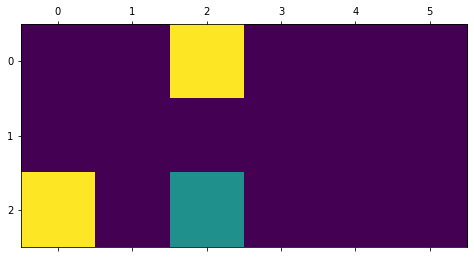

In [12]:
##### import matplotlib.pyplot as plt
import numpy as np

def samplemat(dims, kk, index_nD):
    aa = np.zeros(dims)
    for k in kk:
        aa[k[0], k[1]] = 2
    aa[index_nD[0], index_nD[1]] = 1
    return aa

CA_dimensions = [3, 6]
all_ranks = CA_dimensions[0] * CA_dimensions[1]
max_ranks = all_ranks - 3

index_1D = 14
index_1D = min(index_1D, max_ranks - 1)
mat = samplemat(
    CA_dimensions, get_nD_neighbours(index_1D, max_ranks, CA_dimensions), 
    get_1D_to_nD(index_1D, max_ranks, CA_dimensions))

plt.matshow(mat)

127


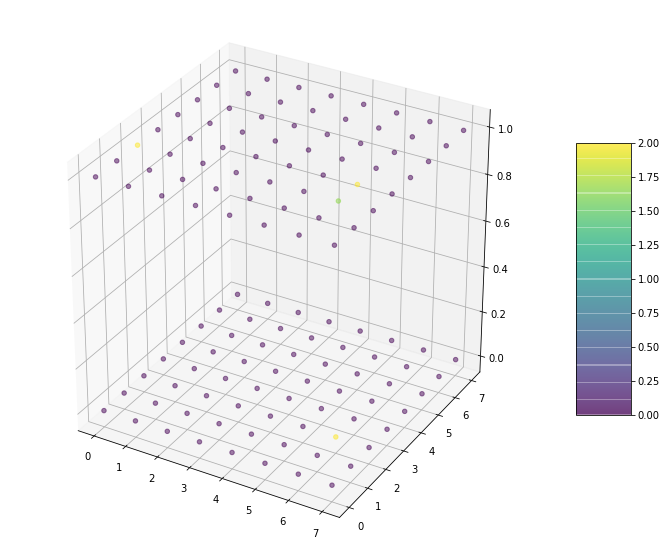

In [13]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def samplemat(dims, kk, index_nD):
    aa = np.zeros(dims)
    for k in kk:
        aa[k[0], k[1], k[2]] = 2
    aa[index_nD[0], index_nD[1], index_nD[2]] = 1.65
    return aa

CA_dimensions = [8, 8, 2]
all_ranks = CA_dimensions[0] * CA_dimensions[1] * CA_dimensions[2]
max_ranks = all_ranks - 12

print((CA_dimensions[0] * CA_dimensions[1] * CA_dimensions[2]) - 1)
index_1D = 114

index_1D = min(index_1D, max_ranks - 1)
mat = samplemat(
    CA_dimensions, get_nD_neighbours(index_1D, max_ranks, CA_dimensions), 
    get_1D_to_nD(index_1D, max_ranks, CA_dimensions))


X, Y, Z = np.mgrid[0:CA_dimensions[0], 0:CA_dimensions[1], 0:CA_dimensions[2]]


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scat = ax.scatter(X, Y, Z, c=mat.flatten(), alpha=0.5)
fig.colorbar(scat, shrink=0.5, aspect=5)

In [14]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np

# x, y, z = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 200).transpose()

# trace1 = go.Scatter3d(
#     x=x,
#     y=y,
#     z=z,
#     mode='markers',
#     marker=dict(
#         size=12,
#         line=dict(
#             color='rgba(217, 217, 217, 0.14)',
#             width=0.5
#         ),
#         opacity=0.8
#     )
# )

# x2, y2, z2 = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 200).transpose()
x2, y2, z2 = np.mgrid[0:CA_dimensions[0], 0:CA_dimensions[1], 0:CA_dimensions[2]]
trace2 = go.Scatter3d(
    x=x2,
    y=y2,
    z=z2,
    mode='markers',
    marker=dict(
        color='rgb(127, 127, 127)',
        size=12,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.9
    )
)
data = [trace2]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

C:\Users\temp3rr0r\Anaconda3\envs\tensorflowLast\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [15]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np

x, y, z = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 200).transpose()
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

x2, y2, z2 = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 200).transpose()
trace2 = go.Scatter3d(
    x=x2,
    y=y2,
    z=z2,
    mode='markers',
    marker=dict(
        color='rgb(127, 127, 127)',
        size=12,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.9
    )
)
data = [trace1, trace2]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

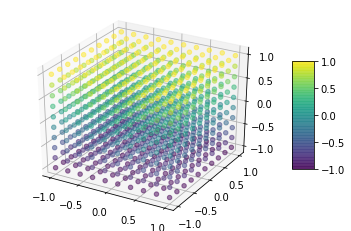

In [16]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

X, Y, Z = np.mgrid[-1:1:10j, -1:1:10j, -1:1:10j]

T = np.exp(-X**2 - Y**2 - Z**2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scat = ax.scatter(X, Y, Z, c=Z.flatten(), alpha=0.5)
fig.colorbar(scat, shrink=0.5, aspect=5)

In [17]:
CA_dimensions = [2, 6]
all_ranks = CA_dimensions[0] * CA_dimensions[1]
max_ranks = all_ranks - 2
print("max_ranks:", max_ranks)
for i in range (0, max_ranks):
    neighbours_1D = get_1D_neighbours(i, max_ranks, CA_dimensions)
    print("{}: {}".format(neighbours_1D, i))

max_ranks: 10
[6, 1]: 0
[7, 2]: 1
[8, 3]: 2
[9, 4]: 3
[4, 5]: 4
[5, 0]: 5
[0, 7]: 6
[1, 8]: 7
[2, 9]: 8
[3, 6]: 9


In [18]:
CA_dimensions = [2, 6]
all_ranks = CA_dimensions[0] * CA_dimensions[1]
max_ranks = all_ranks - 0
for i in range (0, all_ranks):
    neighbours_1D = get_1D_neighbours(i, max_ranks, CA_dimensions)
    print("{}: {}".format(neighbours_1D, i))

[6, 1]: 0
[7, 2]: 1
[8, 3]: 2
[9, 4]: 3
[10, 5]: 4
[11, 0]: 5
[0, 7]: 6
[1, 8]: 7
[2, 9]: 8
[3, 10]: 9
[4, 11]: 10
[5, 6]: 11


In [19]:
CA_dimensions = [2, 6]
all_ranks = CA_dimensions[0] * CA_dimensions[1]
max_ranks = all_ranks - 2
for i in range (0, all_ranks):
    nD_neighbours = get_nD_neighbours(i, max_ranks, CA_dimensions)
    print("{}: {}".format(nD_neighbours, i))

[[1, 0], [0, 1]]: 0
[[1, 1], [0, 2]]: 1
[[1, 2], [0, 3]]: 2
[[1, 3], [0, 4]]: 3
[[0, 4], [0, 5]]: 4
[[0, 5], [0, 0]]: 5
[[0, 0], [1, 1]]: 6
[[0, 1], [1, 2]]: 7
[[0, 2], [1, 3]]: 8
[[0, 3], [1, 0]]: 9
[[0, 4], [1, 0]]: 10
[[0, 5], [1, 0]]: 11


In [20]:
CA_dimensions = [2, 6]
all_ranks = CA_dimensions[0] * CA_dimensions[1]
max_ranks = all_ranks - 0
for i in range (0, all_ranks):
    nD_neighbours = get_nD_neighbours(i, max_ranks, CA_dimensions)
    print("{}: {}".format(nD_neighbours, i))

[[1, 0], [0, 1]]: 0
[[1, 1], [0, 2]]: 1
[[1, 2], [0, 3]]: 2
[[1, 3], [0, 4]]: 3
[[1, 4], [0, 5]]: 4
[[1, 5], [0, 0]]: 5
[[0, 0], [1, 1]]: 6
[[0, 1], [1, 2]]: 7
[[0, 2], [1, 3]]: 8
[[0, 3], [1, 4]]: 9
[[0, 4], [1, 5]]: 10
[[0, 5], [1, 0]]: 11


In [21]:
CA_dimensions = [3, 6]
max_ranks = 3 * 6
for i in range (0, 3 * 6):
    nD = get_1D_to_nD(i, max_ranks, CA_dimensions)
    print("{}: {}({})".format(nD, i,  get_nD_to_1D(nD, max_ranks, CA_dimensions)))

[0, 0]: 0(0)
[0, 1]: 1(1)
[0, 2]: 2(2)
[0, 3]: 3(3)
[0, 4]: 4(4)
[0, 5]: 5(5)
[1, 0]: 6(6)
[1, 1]: 7(7)
[1, 2]: 8(8)
[1, 3]: 9(9)
[1, 4]: 10(10)
[1, 5]: 11(11)
[2, 0]: 12(12)
[2, 1]: 13(13)
[2, 2]: 14(14)
[2, 3]: 15(15)
[2, 4]: 16(16)
[2, 5]: 17(17)


In [22]:
CA_dimensions = [3, 6, 2]
max_ranks = 3 * 6 * 2
for i in range (0, max_ranks):
    nD = get_1D_to_nD(i, max_ranks, CA_dimensions)\
    
    print("{}: {}({})".format(nD, i,  i))
    

[0, 0, 0]: 0(0)
[0, 1, 0]: 1(1)
[0, 2, 0]: 2(2)
[0, 3, 0]: 3(3)
[0, 4, 0]: 4(4)
[0, 5, 0]: 5(5)
[1, 0, 0]: 6(6)
[1, 1, 0]: 7(7)
[1, 2, 0]: 8(8)
[1, 3, 0]: 9(9)
[1, 4, 0]: 10(10)
[1, 5, 0]: 11(11)
[2, 0, 0]: 12(12)
[2, 1, 0]: 13(13)
[2, 2, 0]: 14(14)
[2, 3, 0]: 15(15)
[2, 4, 0]: 16(16)
[2, 5, 0]: 17(17)
[0, 0, 1]: 18(18)
[0, 1, 1]: 19(19)
[0, 2, 1]: 20(20)
[0, 3, 1]: 21(21)
[0, 4, 1]: 22(22)
[0, 5, 1]: 23(23)
[1, 0, 1]: 24(24)
[1, 1, 1]: 25(25)
[1, 2, 1]: 26(26)
[1, 3, 1]: 27(27)
[1, 4, 1]: 28(28)
[1, 5, 1]: 29(29)
[2, 0, 1]: 30(30)
[2, 1, 1]: 31(31)
[2, 2, 1]: 32(32)
[2, 3, 1]: 33(33)
[2, 4, 1]: 34(34)
[2, 5, 1]: 35(35)


In [23]:
CA_dimensions = [6, 3, 4, 2, 5]
max_ranks = 3 * 4 * 2 * 5 * 6

for i in range (0, 3 * 4 * 2 * 5 * 6):
    nD = get_1D_to_nD(i, max_ranks, CA_dimensions)
    print("{}: {}({})".format(nD, i,  get_nD_to_1D(nD, max_ranks, CA_dimensions)))
#     print("{}: {}({})".format(nD, i, i))

[0, 0, 0, 0, 0]: 0(0)
[0, 1, 0, 0, 0]: 1(1)
[0, 2, 0, 0, 0]: 2(2)
[1, 0, 0, 0, 0]: 3(3)
[1, 1, 0, 0, 0]: 4(4)
[1, 2, 0, 0, 0]: 5(5)
[2, 0, 0, 0, 0]: 6(6)
[2, 1, 0, 0, 0]: 7(7)
[2, 2, 0, 0, 0]: 8(8)
[3, 0, 0, 0, 0]: 9(9)
[3, 1, 0, 0, 0]: 10(10)
[3, 2, 0, 0, 0]: 11(11)
[4, 0, 0, 0, 0]: 12(12)
[4, 1, 0, 0, 0]: 13(13)
[4, 2, 0, 0, 0]: 14(14)
[5, 0, 0, 0, 0]: 15(15)
[5, 1, 0, 0, 0]: 16(16)
[5, 2, 0, 0, 0]: 17(17)
[0, 0, 1, 0, 0]: 18(18)
[0, 1, 1, 0, 0]: 19(19)
[0, 2, 1, 0, 0]: 20(20)
[1, 0, 1, 0, 0]: 21(21)
[1, 1, 1, 0, 0]: 22(22)
[1, 2, 1, 0, 0]: 23(23)
[2, 0, 1, 0, 0]: 24(24)
[2, 1, 1, 0, 0]: 25(25)
[2, 2, 1, 0, 0]: 26(26)
[3, 0, 1, 0, 0]: 27(27)
[3, 1, 1, 0, 0]: 28(28)
[3, 2, 1, 0, 0]: 29(29)
[4, 0, 1, 0, 0]: 30(30)
[4, 1, 1, 0, 0]: 31(31)
[4, 2, 1, 0, 0]: 32(32)
[5, 0, 1, 0, 0]: 33(33)
[5, 1, 1, 0, 0]: 34(34)
[5, 2, 1, 0, 0]: 35(35)
[0, 0, 2, 0, 0]: 36(36)
[0, 1, 2, 0, 0]: 37(37)
[0, 2, 2, 0, 0]: 38(38)
[1, 0, 2, 0, 0]: 39(39)
[1, 1, 2, 0, 0]: 40(40)
[1, 2, 2, 0, 0]: 41(41)
[2, 0, 2, 0,

In [24]:
CA_dimensions = [3, 4, 2, 5]
for i in range (0, 3 * 4 * 2 * 5):
    nD = get_1D_to_nD(i, max_ranks, CA_dimensions)
    print("{}: {}({})".format(nD, i,  get_nD_to_1D(nD, max_ranks, CA_dimensions)))
#     print("{}: {}({})".format(nD, i, i))

[0, 0, 0, 0]: 0(0)
[0, 1, 0, 0]: 1(1)
[0, 2, 0, 0]: 2(2)
[0, 3, 0, 0]: 3(3)
[1, 0, 0, 0]: 4(4)
[1, 1, 0, 0]: 5(5)
[1, 2, 0, 0]: 6(6)
[1, 3, 0, 0]: 7(7)
[2, 0, 0, 0]: 8(8)
[2, 1, 0, 0]: 9(9)
[2, 2, 0, 0]: 10(10)
[2, 3, 0, 0]: 11(11)
[0, 0, 1, 0]: 12(12)
[0, 1, 1, 0]: 13(13)
[0, 2, 1, 0]: 14(14)
[0, 3, 1, 0]: 15(15)
[1, 0, 1, 0]: 16(16)
[1, 1, 1, 0]: 17(17)
[1, 2, 1, 0]: 18(18)
[1, 3, 1, 0]: 19(19)
[2, 0, 1, 0]: 20(20)
[2, 1, 1, 0]: 21(21)
[2, 2, 1, 0]: 22(22)
[2, 3, 1, 0]: 23(23)
[0, 0, 0, 1]: 24(24)
[0, 1, 0, 1]: 25(25)
[0, 2, 0, 1]: 26(26)
[0, 3, 0, 1]: 27(27)
[1, 0, 0, 1]: 28(28)
[1, 1, 0, 1]: 29(29)
[1, 2, 0, 1]: 30(30)
[1, 3, 0, 1]: 31(31)
[2, 0, 0, 1]: 32(32)
[2, 1, 0, 1]: 33(33)
[2, 2, 0, 1]: 34(34)
[2, 3, 0, 1]: 35(35)
[0, 0, 1, 1]: 36(36)
[0, 1, 1, 1]: 37(37)
[0, 2, 1, 1]: 38(38)
[0, 3, 1, 1]: 39(39)
[1, 0, 1, 1]: 40(40)
[1, 1, 1, 1]: 41(41)
[1, 2, 1, 1]: 42(42)
[1, 3, 1, 1]: 43(43)
[2, 0, 1, 1]: 44(44)
[2, 1, 1, 1]: 45(45)
[2, 2, 1, 1]: 46(46)
[2, 3, 1, 1]: 47(47)
[0, 0, 0, 2]

In [25]:
CA_dimensions = [3, 6, 2]
for i in range (0, 3 * 6 * 2):
    nD = get_1D_to_nD(i, max_ranks, CA_dimensions)
    print("{}: {}({})".format(nD, i,  get_nD_to_1D(nD, max_ranks, CA_dimensions)))

[0, 0, 0]: 0(0)
[0, 1, 0]: 1(1)
[0, 2, 0]: 2(2)
[0, 3, 0]: 3(3)
[0, 4, 0]: 4(4)
[0, 5, 0]: 5(5)
[1, 0, 0]: 6(6)
[1, 1, 0]: 7(7)
[1, 2, 0]: 8(8)
[1, 3, 0]: 9(9)
[1, 4, 0]: 10(10)
[1, 5, 0]: 11(11)
[2, 0, 0]: 12(12)
[2, 1, 0]: 13(13)
[2, 2, 0]: 14(14)
[2, 3, 0]: 15(15)
[2, 4, 0]: 16(16)
[2, 5, 0]: 17(17)
[0, 0, 1]: 18(18)
[0, 1, 1]: 19(19)
[0, 2, 1]: 20(20)
[0, 3, 1]: 21(21)
[0, 4, 1]: 22(22)
[0, 5, 1]: 23(23)
[1, 0, 1]: 24(24)
[1, 1, 1]: 25(25)
[1, 2, 1]: 26(26)
[1, 3, 1]: 27(27)
[1, 4, 1]: 28(28)
[1, 5, 1]: 29(29)
[2, 0, 1]: 30(30)
[2, 1, 1]: 31(31)
[2, 2, 1]: 32(32)
[2, 3, 1]: 33(33)
[2, 4, 1]: 34(34)
[2, 5, 1]: 35(35)


In [26]:
CA_dimensions = [3, 6, 2, 3]
max_ranks = 108

for l in range (0, CA_dimensions[3]):
    for k in range (0, CA_dimensions[2]):
        for i in range(0, CA_dimensions[0]):   
            for j in range(0, CA_dimensions[1]):             
                index_nD = [i, j, k, l]
                print("{}: {}".format(index_nD, get_nD_to_1D(index_nD, max_ranks, CA_dimensions)))

[0, 0, 0, 0]: 0
[0, 1, 0, 0]: 1
[0, 2, 0, 0]: 2
[0, 3, 0, 0]: 3
[0, 4, 0, 0]: 4
[0, 5, 0, 0]: 5
[1, 0, 0, 0]: 6
[1, 1, 0, 0]: 7
[1, 2, 0, 0]: 8
[1, 3, 0, 0]: 9
[1, 4, 0, 0]: 10
[1, 5, 0, 0]: 11
[2, 0, 0, 0]: 12
[2, 1, 0, 0]: 13
[2, 2, 0, 0]: 14
[2, 3, 0, 0]: 15
[2, 4, 0, 0]: 16
[2, 5, 0, 0]: 17
[0, 0, 1, 0]: 18
[0, 1, 1, 0]: 19
[0, 2, 1, 0]: 20
[0, 3, 1, 0]: 21
[0, 4, 1, 0]: 22
[0, 5, 1, 0]: 23
[1, 0, 1, 0]: 24
[1, 1, 1, 0]: 25
[1, 2, 1, 0]: 26
[1, 3, 1, 0]: 27
[1, 4, 1, 0]: 28
[1, 5, 1, 0]: 29
[2, 0, 1, 0]: 30
[2, 1, 1, 0]: 31
[2, 2, 1, 0]: 32
[2, 3, 1, 0]: 33
[2, 4, 1, 0]: 34
[2, 5, 1, 0]: 35
[0, 0, 0, 1]: 36
[0, 1, 0, 1]: 37
[0, 2, 0, 1]: 38
[0, 3, 0, 1]: 39
[0, 4, 0, 1]: 40
[0, 5, 0, 1]: 41
[1, 0, 0, 1]: 42
[1, 1, 0, 1]: 43
[1, 2, 0, 1]: 44
[1, 3, 0, 1]: 45
[1, 4, 0, 1]: 46
[1, 5, 0, 1]: 47
[2, 0, 0, 1]: 48
[2, 1, 0, 1]: 49
[2, 2, 0, 1]: 50
[2, 3, 0, 1]: 51
[2, 4, 0, 1]: 52
[2, 5, 0, 1]: 53
[0, 0, 1, 1]: 54
[0, 1, 1, 1]: 55
[0, 2, 1, 1]: 56
[0, 3, 1, 1]: 57
[0, 4, 1, 1]: 58
[0, 5, 

In [27]:
CA_dimensions = [3, 6, 2]

for k in range (0, CA_dimensions[2]):
    for i in range(0, CA_dimensions[0]):   
        for j in range(0, CA_dimensions[1]):             
            index_nD = [i, j, k]
            print("{}: {}".format(index_nD, get_nD_to_1D(index_nD, max_ranks, CA_dimensions)))

[0, 0, 0]: 0
[0, 1, 0]: 1
[0, 2, 0]: 2
[0, 3, 0]: 3
[0, 4, 0]: 4
[0, 5, 0]: 5
[1, 0, 0]: 6
[1, 1, 0]: 7
[1, 2, 0]: 8
[1, 3, 0]: 9
[1, 4, 0]: 10
[1, 5, 0]: 11
[2, 0, 0]: 12
[2, 1, 0]: 13
[2, 2, 0]: 14
[2, 3, 0]: 15
[2, 4, 0]: 16
[2, 5, 0]: 17
[0, 0, 1]: 18
[0, 1, 1]: 19
[0, 2, 1]: 20
[0, 3, 1]: 21
[0, 4, 1]: 22
[0, 5, 1]: 23
[1, 0, 1]: 24
[1, 1, 1]: 25
[1, 2, 1]: 26
[1, 3, 1]: 27
[1, 4, 1]: 28
[1, 5, 1]: 29
[2, 0, 1]: 30
[2, 1, 1]: 31
[2, 2, 1]: 32
[2, 3, 1]: 33
[2, 4, 1]: 34
[2, 5, 1]: 35


In [28]:
CA_dimensions = [3, 6]
for i in range(0, CA_dimensions[0]):
    for j in range(0, CA_dimensions[1]):
        index_nD = [i, j]
        print("{}: {}".format(index_nD, get_nD_to_1D(index_nD, max_ranks, CA_dimensions)))

[0, 0]: 0
[0, 1]: 1
[0, 2]: 2
[0, 3]: 3
[0, 4]: 4
[0, 5]: 5
[1, 0]: 6
[1, 1]: 7
[1, 2]: 8
[1, 3]: 9
[1, 4]: 10
[1, 5]: 11
[2, 0]: 12
[2, 1]: 13
[2, 2]: 14
[2, 3]: 15
[2, 4]: 16
[2, 5]: 17


In [29]:
CA_dimensions = [3, 2, 2, 3, 2, 3]
max_ranks = 108 * 2

for y in range (0, CA_dimensions[5]):
    for x in range (0, CA_dimensions[4]):
        for l in range (0, CA_dimensions[3]):
            for k in range (0, CA_dimensions[2]):
                for i in range(0, CA_dimensions[0]):   
                    for j in range(0, CA_dimensions[1]):             
                        index_nD = [i, j, k, l, x, y]
                        print("{}: {}".format(index_nD, get_nD_to_1D(index_nD, max_ranks, CA_dimensions)))

[0, 0, 0, 0, 0, 0]: 0
[0, 1, 0, 0, 0, 0]: 1
[1, 0, 0, 0, 0, 0]: 2
[1, 1, 0, 0, 0, 0]: 3
[2, 0, 0, 0, 0, 0]: 4
[2, 1, 0, 0, 0, 0]: 5
[0, 0, 1, 0, 0, 0]: 6
[0, 1, 1, 0, 0, 0]: 7
[1, 0, 1, 0, 0, 0]: 8
[1, 1, 1, 0, 0, 0]: 9
[2, 0, 1, 0, 0, 0]: 10
[2, 1, 1, 0, 0, 0]: 11
[0, 0, 0, 1, 0, 0]: 12
[0, 1, 0, 1, 0, 0]: 13
[1, 0, 0, 1, 0, 0]: 14
[1, 1, 0, 1, 0, 0]: 15
[2, 0, 0, 1, 0, 0]: 16
[2, 1, 0, 1, 0, 0]: 17
[0, 0, 1, 1, 0, 0]: 18
[0, 1, 1, 1, 0, 0]: 19
[1, 0, 1, 1, 0, 0]: 20
[1, 1, 1, 1, 0, 0]: 21
[2, 0, 1, 1, 0, 0]: 22
[2, 1, 1, 1, 0, 0]: 23
[0, 0, 0, 2, 0, 0]: 24
[0, 1, 0, 2, 0, 0]: 25
[1, 0, 0, 2, 0, 0]: 26
[1, 1, 0, 2, 0, 0]: 27
[2, 0, 0, 2, 0, 0]: 28
[2, 1, 0, 2, 0, 0]: 29
[0, 0, 1, 2, 0, 0]: 30
[0, 1, 1, 2, 0, 0]: 31
[1, 0, 1, 2, 0, 0]: 32
[1, 1, 1, 2, 0, 0]: 33
[2, 0, 1, 2, 0, 0]: 34
[2, 1, 1, 2, 0, 0]: 35
[0, 0, 0, 0, 1, 0]: 36
[0, 1, 0, 0, 1, 0]: 37
[1, 0, 0, 0, 1, 0]: 38
[1, 1, 0, 0, 1, 0]: 39
[2, 0, 0, 0, 1, 0]: 40
[2, 1, 0, 0, 1, 0]: 41
[0, 0, 1, 0, 1, 0]: 42
[0, 1, 1, 0, 1, 0]: 4

In [30]:
CA_dimensions = [3, 6, 2, 3, 2]
max_ranks = 108 * 2

for x in range (0, CA_dimensions[4]):
    for l in range (0, CA_dimensions[3]):
        for k in range (0, CA_dimensions[2]):
            for i in range(0, CA_dimensions[0]):   
                for j in range(0, CA_dimensions[1]):             
                    index_nD = [i, j, k, l, x]
                    print("{}: {}".format(index_nD, get_nD_to_1D(index_nD, max_ranks, CA_dimensions)))

[0, 0, 0, 0, 0]: 0
[0, 1, 0, 0, 0]: 1
[0, 2, 0, 0, 0]: 2
[0, 3, 0, 0, 0]: 3
[0, 4, 0, 0, 0]: 4
[0, 5, 0, 0, 0]: 5
[1, 0, 0, 0, 0]: 6
[1, 1, 0, 0, 0]: 7
[1, 2, 0, 0, 0]: 8
[1, 3, 0, 0, 0]: 9
[1, 4, 0, 0, 0]: 10
[1, 5, 0, 0, 0]: 11
[2, 0, 0, 0, 0]: 12
[2, 1, 0, 0, 0]: 13
[2, 2, 0, 0, 0]: 14
[2, 3, 0, 0, 0]: 15
[2, 4, 0, 0, 0]: 16
[2, 5, 0, 0, 0]: 17
[0, 0, 1, 0, 0]: 18
[0, 1, 1, 0, 0]: 19
[0, 2, 1, 0, 0]: 20
[0, 3, 1, 0, 0]: 21
[0, 4, 1, 0, 0]: 22
[0, 5, 1, 0, 0]: 23
[1, 0, 1, 0, 0]: 24
[1, 1, 1, 0, 0]: 25
[1, 2, 1, 0, 0]: 26
[1, 3, 1, 0, 0]: 27
[1, 4, 1, 0, 0]: 28
[1, 5, 1, 0, 0]: 29
[2, 0, 1, 0, 0]: 30
[2, 1, 1, 0, 0]: 31
[2, 2, 1, 0, 0]: 32
[2, 3, 1, 0, 0]: 33
[2, 4, 1, 0, 0]: 34
[2, 5, 1, 0, 0]: 35
[0, 0, 0, 1, 0]: 36
[0, 1, 0, 1, 0]: 37
[0, 2, 0, 1, 0]: 38
[0, 3, 0, 1, 0]: 39
[0, 4, 0, 1, 0]: 40
[0, 5, 0, 1, 0]: 41
[1, 0, 0, 1, 0]: 42
[1, 1, 0, 1, 0]: 43
[1, 2, 0, 1, 0]: 44
[1, 3, 0, 1, 0]: 45
[1, 4, 0, 1, 0]: 46
[1, 5, 0, 1, 0]: 47
[2, 0, 0, 1, 0]: 48
[2, 1, 0, 1, 0]: 49
[2, 2, 0, 

In [31]:
CA_dimensions = [3, 6, 2]
max_ranks = 27
index_nD = [1, 3, 1]
returned_1D = get_nD_to_1D(index_nD, max_ranks, CA_dimensions)
print("index_nD: {}, returned_1D: {}".format(index_nD, returned_1D))

CA_dimensions = [3, 6]
max_ranks = 18
index_nD = [2, 2]
returned_1D = get_nD_to_1D(index_nD, max_ranks, CA_dimensions)
print("index_nD: {}, returned_1D: {}".format(index_nD, returned_1D))

CA_dimensions = [3, 6]
max_ranks = 18
index_nD = [1, 2]
returned_1D = get_nD_to_1D(index_nD, max_ranks, CA_dimensions)
print("index_nD: {}, returned_1D: {}".format(index_nD, returned_1D))


index_nD: [1, 3, 1], returned_1D: 27
index_nD: [2, 2], returned_1D: 14
index_nD: [1, 2], returned_1D: 8


In [32]:
CA_dimensions = [3, 6, 2]
max_ranks = 27
index_1D = 27
index_nD = get_1D_to_nD(index_1D, max_ranks, CA_dimensions)

In [33]:
CA_dimensions = [3, 6, 2, 3]
max_ranks = 108

index_1D = 107
index_nD = get_1D_to_nD(index_1D, max_ranks, CA_dimensions)